### Dirichlet Multinomial Mixtures (DMM) is a cluster analysis Of microbiome data.
### To be more specific, it is a probabilistic method for community typing (or clustering) of microbial community profiling data. It is an infinite mixture model, which means that the method can infer the optimal number of community types. Note that the number of community types is likely to grow with data size.

#### Prepare

In [ ]:
# Import packages
BiocManager::install("DirichletMultinomial")
library("microbiome")
library("DirichletMultinomial")
library("reshape2")
library("magrittr")
library("dplyr")

In [25]:
# Import data
data(dietswap)
pseq <- dietswap

# To speed up, only consider the core taxa
# that are prevalent at 0.1% relative abundance in 50% of the samples
pseq.comp <- microbiome::transform(pseq, "compositional")
taxa <- core_members(pseq.comp, detection = 0.1/100, prevalence = 50/100)
pseq <- prune_taxa(taxa, pseq)

# Pick the OTU count matrix
# and convert it into samples x taxa format
dat <- abundances(pseq)
count <- as.matrix(t(dat))

head(dat)

,Sample-1,Sample-2,Sample-3,Sample-4,Sample-5,Sample-6,Sample-7,Sample-8,Sample-9,Sample-10,⋯,Sample-213,Sample-214,Sample-215,Sample-216,Sample-217,Sample-218,Sample-219,Sample-220,Sample-221,Sample-222
Akkermansia,18,97,67,256,21,16,26,30,19,125,⋯,39,17,189,64,31,12,15,22,75,45
Allistipes et rel.,336,63,36,96,49,17,47,49,14,31,⋯,72,37,99,102,56,105,709,70,160,68
Anaerostipes caccae et rel.,244,137,27,36,23,29,58,49,23,29,⋯,31,24,15,14,92,13,26,60,27,73
Anaerotruncus colihominis et rel.,12,108,203,68,15,36,31,40,19,720,⋯,147,183,192,323,302,168,113,22,94,163
Bacteroides fragilis et rel.,443,21,73,29,33,14,22,560,8,26,⋯,39,54,366,499,67,64,132,43,734,257
Bacteroides ovatus et rel.,427,15,31,46,29,13,15,19,7,11,⋯,30,18,24,31,20,22,241,32,36,41


#### Fit the DMM model. 
#### Let us set the maximum allowed number of community types to 6 to speed up the example.

In [14]:
fit <- mclapply(1:6, dmn, count = count, verbose = TRUE)

#### Check model fit with different number of mixture components using standard information criteria.

In [15]:
lplc <- sapply(fit, laplace) # AIC / BIC / Laplace
aic  <- sapply(fit, AIC) # AIC / BIC / Laplace
bic  <- sapply(fit, BIC) # AIC / BIC / Laplace

#### Pick the optimal model

In [26]:
best <- fit[[which.min(aic)]]

best

class: DMN 
k: 6 
samples x taxa: 222 x 52 
Laplace: 63764.58 BIC: 63871.39 AIC: 63332.07 

#### Mixture parameters pi and theta

In [18]:
mixturewt(best)

pi,theta
<dbl>,<dbl>
0.2697056,103.41323
0.1709113,235.36881
0.1501499,55.19356
0.1475990,116.91250
0.1393112,388.13690
0.1223230,88.92080


#### Sample-component assignments

In [29]:
ass <- apply(mixture(best), 1, which.max)

head(ass)

Sample-1 Sample-2 Sample-3 Sample-4 Sample-5 Sample-6 
       1        4        2        3        2        5

#### Check contribution of each taxonomic group to each component

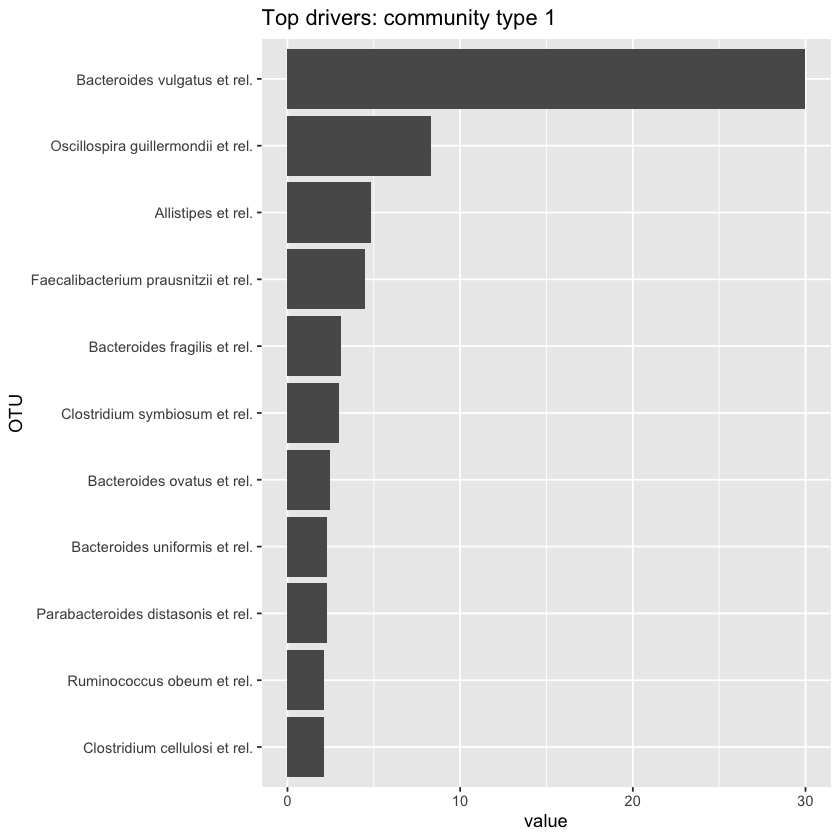

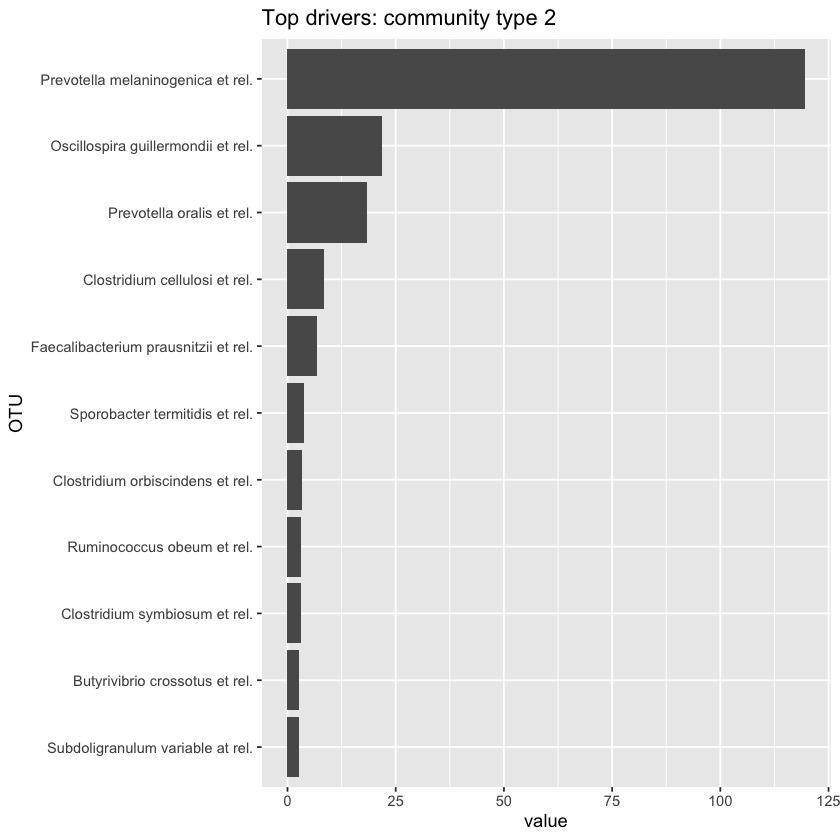

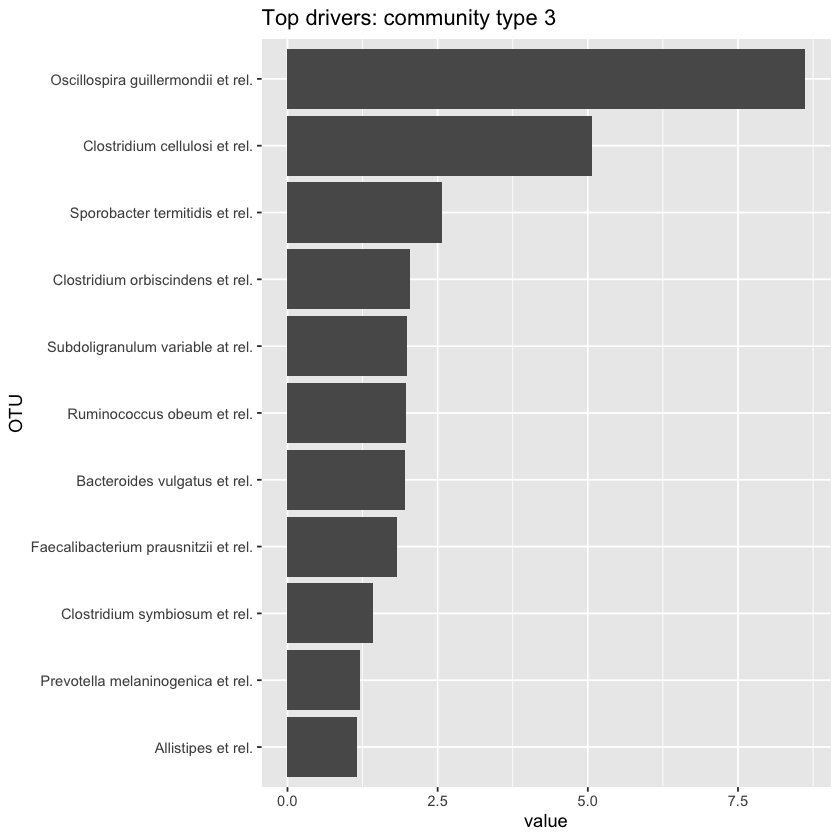

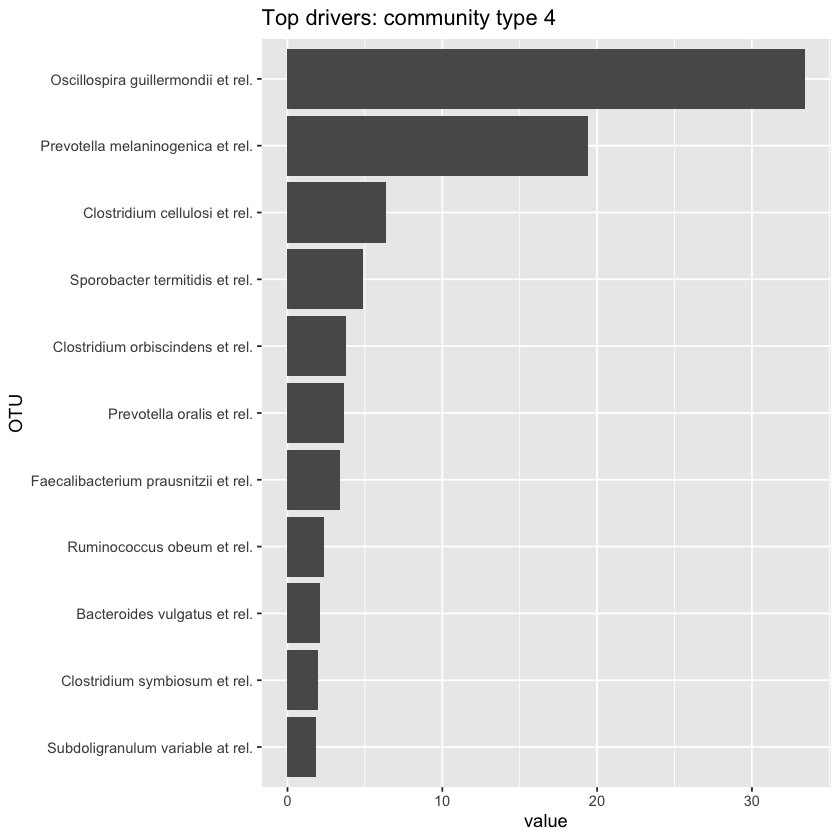

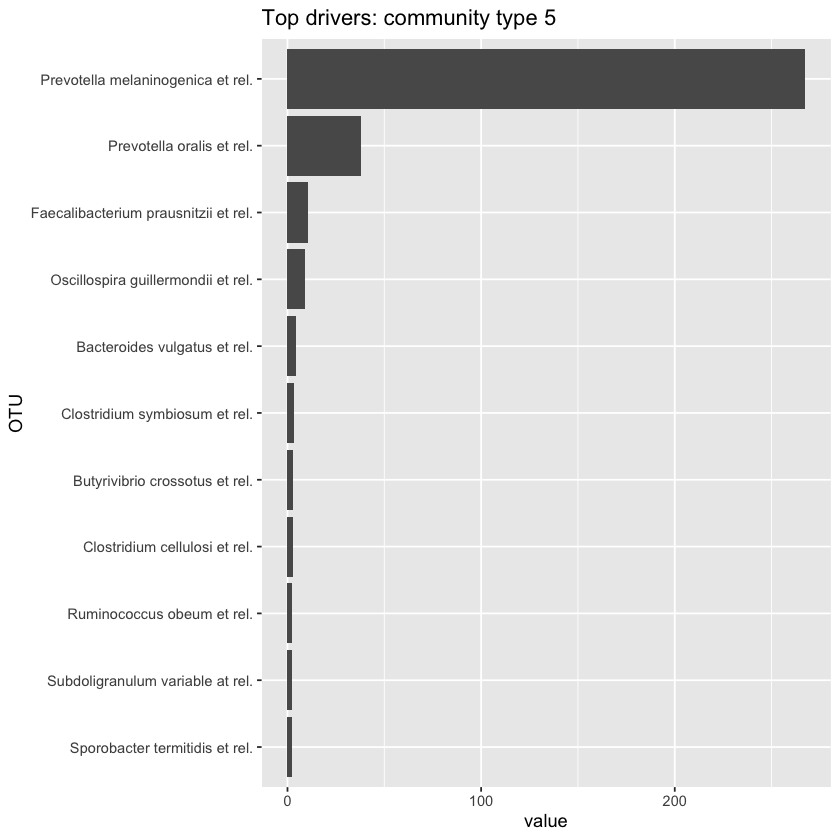

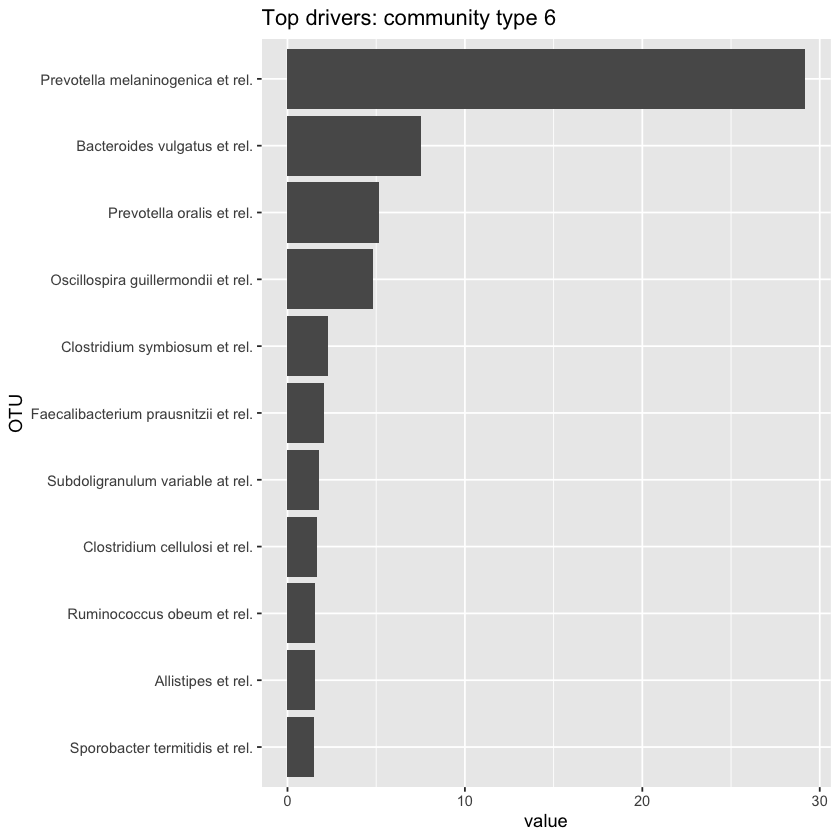

In [21]:
for (k in seq(ncol(fitted(best)))) {
  d <- melt(fitted(best))
  colnames(d) <- c("OTU", "cluster", "value")
  d <- subset(d, cluster == k) %>%
     # Arrange OTUs by assignment strength
     arrange(value) %>%
     mutate(OTU = factor(OTU, levels = unique(OTU))) %>%
     # Only show the most important drivers
     filter(abs(value) > quantile(abs(value), 0.8))     

  p <- ggplot(d, aes(x = OTU, y = value)) +
       geom_bar(stat = "identity") +
       coord_flip() +
       labs(title = paste("Top drivers: community type", k))
  print(p)
}